In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Get the data

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data preparation 
- Select only the features from above and fill in the missing values with 0.
- Create a new column rooms_per_household by dividing the column total_rooms by the column households from dataframe.
- Create a new column bedrooms_per_room by dividing the column total_bedrooms by the column total_rooms from dataframe.
- Create a new column population_per_household by dividing the column population by the column households from dataframe.

In [4]:
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms',
         'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']]

In [5]:
df = df.fillna(0)

In [6]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

### Make median_house_value binary
- We need to turn the median_house_value variable from numeric into binary.
- Let's create a variable above_average which is 1 if the median_house_value is above its mean value and 0 otherwise.

In [7]:
df['above_average'] = df['median_house_value'].apply(lambda x: 1 if x > df['median_house_value'].mean() else 0)

In [8]:
df['above_average'].value_counts(normalize=True)

0    0.59375
1    0.40625
Name: above_average, dtype: float64

### Feature Importance
* Difference
* Risk Ratio
* mutual info
* correlation

## Question 1
What is the most frequent observation (mode) for the column ocean_proximity?

In [9]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Answer = <1h ocean

## Question 2
- Create the correlation matrix for the numerical features of your train dataset.  
 - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset. 

What are the two features that have the biggest correlation in this dataset?

<AxesSubplot:>

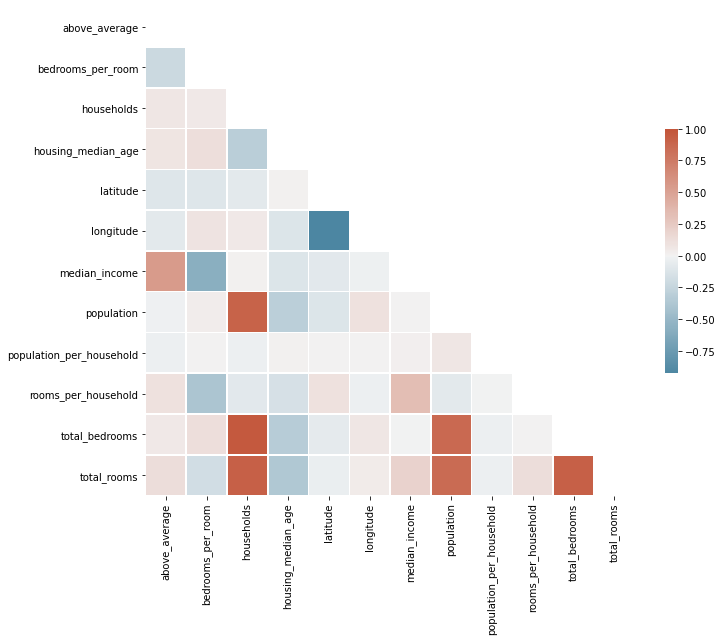

In [10]:
corr = df[(df.select_dtypes(include=np.number).columns.difference(['median_house_value']))].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
sol = (corr.where(np.triu(corr, k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

In [12]:
sol.head(1)

households  total_bedrooms    0.966507
dtype: float64

### Answer = total_bedrooms and households

## Split the data
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value (median_house_value) is not in your dataframe.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df_full_train, df_test = train_test_split(
    df[(df.columns.difference(['median_house_value']))], test_size=.2, random_state=42)

In [15]:
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=42)

In [16]:
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

## Question 3
- Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
- What is the value of mutual information?
- Round it to 2 decimal digits using round(score, 2)

https://en.wikipedia.org/wiki/Mutual_information

In [17]:
from sklearn.metrics import mutual_info_score

In [18]:
df.dtypes

latitude                    float64
longitude                   float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
median_house_value          float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
above_average                 int64
dtype: object

In [19]:
round(mutual_info_score(df_train.above_average, df_train.ocean_proximity), 3)

0.101

### Answer = 0.101

## Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable `ocean_proximity` in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [20]:
y_train, y_val, y_test = df_train['above_average'], df_val['above_average'], df_test['above_average']
for df_ in [df_train, df_val, df_test]:
    del df_['above_average']  

### One-hot encoding

In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [22]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [46]:
train_dict[:5]

[{'bedrooms_per_room': 0.25971370143149286,
  'households': 374.0,
  'housing_median_age': 39.0,
  'latitude': 34.43,
  'longitude': -119.67,
  'median_income': 2.3681,
  'ocean_proximity': '<1H OCEAN',
  'population': 1404.0,
  'population_per_household': 3.7540106951871657,
  'rooms_per_household': 3.9224598930481283,
  'total_bedrooms': 381.0,
  'total_rooms': 1467.0},
 {'bedrooms_per_room': 0.13022798097424962,
  'households': 806.0,
  'housing_median_age': 24.0,
  'latitude': 33.74,
  'longitude': -118.32,
  'median_income': 10.1357,
  'ocean_proximity': 'NEAR OCEAN',
  'population': 2248.0,
  'population_per_household': 2.7890818858560795,
  'rooms_per_household': 7.564516129032258,
  'total_bedrooms': 794.0,
  'total_rooms': 6097.0},
 {'bedrooms_per_room': 0.23462414578587698,
  'households': 337.0,
  'housing_median_age': 41.0,
  'latitude': 39.13,
  'longitude': -121.62,
  'median_income': 1.6719,
  'ocean_proximity': 'INLAND',
  'population': 856.0,
  'population_per_househol

In [24]:
# sparse - is a matrix that is comprised of mostly zero values.
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [25]:
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [26]:
list(X_train[:5][0])

[0.25971370143149286,
 374.0,
 39.0,
 34.43,
 -119.67,
 2.3681,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1404.0,
 3.7540106951871657,
 3.9224598930481283,
 381.0,
 1467.0]

In [27]:
dv.get_feature_names()

['bedrooms_per_room',
 'households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'population_per_household',
 'rooms_per_household',
 'total_bedrooms',
 'total_rooms']

In [28]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.8359980620155039


In [29]:
model.predict_proba(X_train)

array([[8.86130922e-01, 1.13869078e-01],
       [6.17766286e-04, 9.99382234e-01],
       [9.80558072e-01, 1.94419276e-02],
       ...,
       [6.68219736e-01, 3.31780264e-01],
       [3.33224156e-01, 6.66775844e-01],
       [4.04331495e-01, 5.95668505e-01]])

In [30]:
dict(zip(dv.get_feature_names(), model.coef_.round(5)))

{'bedrooms_per_room': array([ 1.13420e-01,  4.04000e-03,  3.57200e-02,  1.02630e-01,
         8.27400e-02,  1.19639e+00,  4.52130e-01, -1.59851e+00,
         1.19100e-02,  3.09190e-01,  7.63020e-01, -1.63000e-03,
         1.04800e-02, -1.36700e-02,  1.81000e-03, -1.50000e-04])}

### Answer = 0.84

### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 
* Which of following feature has the smallest difference? 
   * `total_rooms`
   * `total_bedrooms` 
   * `population`
   * `households`

> **note**: the difference doesn't have to be positive

In [31]:
type(X_train)

numpy.ndarray

In [32]:
orig_score = accuracy

differences = {}
features = list(df_train.columns.copy())
for col in features:
    subset = features.copy()
    subset.remove(col)
    train_dict = df_train[subset].to_dict(orient='records')
    val_dict = df_val[subset].to_dict(orient='records')
    # sparse - is a matrix that is comprised of mostly zero values.
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    differences[col] = orig_score - accuracy

In [33]:
sorted(differences.items(), key=lambda x: x[1])

[('total_bedrooms', -0.001211240310077577),
 ('bedrooms_per_room', -0.00024224806201555982),
 ('total_rooms', -0.00024224806201555982),
 ('population_per_household', 0.0002422480620154488),
 ('rooms_per_household', 0.0007267441860464574),
 ('households', 0.0019379844961240345),
 ('latitude', 0.003633720930232509),
 ('longitude', 0.004118217054263518),
 ('housing_median_age', 0.0043604651162790775),
 ('population', 0.009689922480620172),
 ('ocean_proximity', 0.015746124031007724),
 ('median_income', 0.050629844961240345)]

### Answer = 'total rooms'

## Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column `'median_house_value'`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model (`model = Ridge(alpha=a, solver="sag", random_state=42)`) on the training data.
* This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest `alpha`.

In [34]:
df['median_house_value']=np.log1p(df['median_house_value'])

In [35]:
df_full_train, df_test = train_test_split(
    df[(df.columns.difference(['above_average']))], test_size=.2, random_state=42)

In [36]:
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=42)

In [37]:
y_train, y_val, y_test = df_train['median_house_value'], df_val['median_house_value'], df_test['median_house_value']
for df_ in [df_train, df_val, df_test]:
    del df_['median_house_value']  

In [38]:
train_dict = df_train.iloc[:].to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [39]:
# sparse - is a matrix that is comprised of mostly zero values.
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [40]:
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [41]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [42]:
for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=True)
    print(a, round(rmse, 3))

0 0.275
0.01 0.275
0.1 0.275
1 0.275
10 0.275


In [43]:
model.coef_

array([-1.23535851e-05,  1.46792452e-03,  3.78849037e-03, -1.62015918e-03,
        1.30099914e-04,  3.16742060e-03,  5.93558621e-04, -8.77043886e-04,
        1.00095081e-06,  1.31615066e-04,  1.50869249e-04, -2.80754944e-04,
        4.18390805e-04,  6.00905306e-04, -1.43943760e-03,  1.96864724e-04])

In [44]:
model.intercept_

11.956075603133666

In [45]:
model.predict(X_train)

array([11.93969303, 12.62428837, 12.10885983, ..., 12.08779275,
       12.06835275, 12.07351078])

### Answer = 0